### 6.3.1　温度预测问题

在这个数据集中，每10 分钟记录14 个不同的量（比如气温、气压、湿度、风向等），其中
包含多年的记录。原始数据可追溯到2003 年，但本例仅使用2009—2016 年的数据。这个数据
集非常适合用来学习处理数值型时间序列。我们将会用这个数据集来构建模型，输入最近的一
些数据（几天的数据点），可以预测24 小时之后的气温。

下载并解压数据，如下所示。

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/data/")

In [4]:
!pwd
!ls

/content/drive/My Drive/data
aclImdb      cats_and_dogs_small  glove.6B	test.zip
aclImdb.zip  dogs-vs-cats	  jena_climate	train.zip
cat_cam.jpg  dogs-vs-cats.zip	  models


In [4]:
!mkdir jena_climate
!cd jena_climate
!pwd

/content/drive/My Drive/data


In [0]:
os.chdir('/content/drive/My Drive/data/jena_climate')

In [6]:
!pwd

/content/drive/My Drive/data/jena_climate


In [7]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2019-08-07 06:38:07--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.106.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.106.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  26.9MB/s    in 0.5s    

2019-08-07 06:38:07 (26.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [9]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [11]:
!ls -lh

total 55M
-rw------- 1 root root 42M Mar 19  2017 jena_climate_2009_2016.csv
-rw------- 1 root root 13M Mar 21  2017 jena_climate_2009_2016.csv.zip


* 来观察一下数据

In [5]:
data_dir = '/content/drive/My Drive/data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


* 接下来，将420 551 行数据转换成一个Numpy 数组。

In [0]:
import numpy as np

In [0]:
float_data = np.zeros((len(lines),len(header)-1))

for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i,:] = values

* 绘制温度时间序列

In [0]:
from matplotlib import pyplot as plt

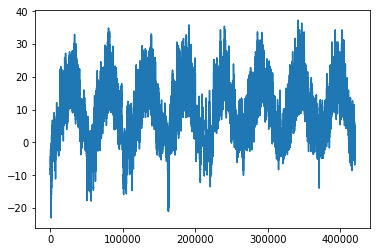

In [9]:
temp = float_data[:,1] #温度（单位：摄氏度）
plt.plot(range(len(temp)),temp)

给出了前10 天温度数据的图像。因为每10 分钟记录一个数据，所以每天有144 个
数据点。
* 　绘制前10 天的温度时间序列

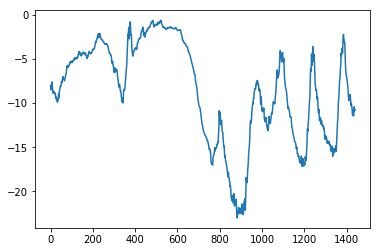

In [10]:
plt.plot(range(1440),temp[:1440])

### 6.3.2　准备数据
这个问题的确切表述如下：一个时间步是10 分钟，每steps 个时间步采样一次数据，给
定过去lookback 个时间步之内的数据，能否预测delay 个时间步之后的温度？用到的参数值
如下。
*  lookback = 720：给定过去5 天内的观测数据。
* steps = 6：观测数据的采样频率是每小时一个数据点。
* delay = 144：目标是未来 24 小时之后的数据。

开始之前，你需要完成以下两件事。
* 将数据预处理为神经网络可以处理的格式。这很简单。数据已经是数值型的，所以不需
要做向量化。但数据中的每个时间序列位于不同的范围（比如温度通道位于-20 到+30
之间，但气压大约在1000 毫巴上下）。你需要对每个时间序列分别做标准化，让它们在
相似的范围内都取较小的值。
*  编写一个 Python 生成器，以当前的浮点数数组作为输入，并从最近的数据中生成数据批
量，同时生成未来的目标温度。因为数据集中的样本是高度冗余的（对于第N 个样本和
第N+1 个样本，大部分时间步都是相同的），所以显式地保存每个样本是一种浪费。相反，
我们将使用原始数据即时生成样本。

预处理数据的方法是，将每个时间序列减去其平均值，然后除以其标准差。我们将使用前
200 000 个时间步作为训练数据，所以只对这部分数据计算平均值和标准差。

- 数据标准化

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -=mean
std = float_data[:200000].std(axis=0)
float_data /= std

将要用到的生成器。它生成了一个元组(samples, targets)，其
中samples 是输入数据的一个批量，targets 是对应的目标温度数组。生成器的参数如下。
* data：浮点数数据组成的原始数组，在代码清单 6-32 中将其标准化。
* lookback：输入数据应该包括过去多少个时间步。
* delay：目标应该在未来多少个时间步之后。
* min_index 和 max_index：data 数组中的索引，用于界定需要抽取哪些时间步。这有
助于保存一部分数据用于验证、另一部分用于测试。
* shuffle：是打乱样本，还是按顺序抽取样本。
* batch_size：每个批量的样本数。
* step：数据采样的周期（单位：时间步）。我们将其设为6，为的是每小时抽取一个数据点。

生成时间序列样本及其目标的生成器

In [0]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) -delay -1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i,min(i+ batch_size, max_index))
      i += len(rows)
      
    samples = np.zeros((len(rows),
                       lookback // step,
                       data.shape[-1]))
    targets = np.zeros((len(rows),))
    
    for j,row in enumerate(rows):
      indices = range(rows[j] - lookback,rows[j],step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
      
    yield samples, targets

下面，我们使用这个抽象的generator 函数来实例化三个生成器：一个用于训练，一个用于验证，还有一个用于测试。每个生成器分别读取原始数据的不同时间段：训练生成器读取前
200 000 个时间步，验证生成器读取随后的100 000 个时间步，测试生成器读取剩下的时间步。

- 准备训练生成器、验证生成器和测试生成器

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128


In [0]:
train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size #为了查看整个验证集，需要从val_gen 中抽取多少次

test_steps = (len(float_data) - 300001 - lookback) // batch_size #为了查看整个测试集，需要从test_gen 中抽取多少次


### 6.3.3　一种基于常识的、非机器学习的基准方法

- 计算符合常识的基准方法的MAE

In [15]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
  
evaluate_naive_method()

0.2884002016391944


### 6.3.4　一种基本的机器学习方法

一个密集连接模型，首先将数据展平，然后通过两个Dense 层并运行。
注意，最后一个Dense 层没有使用激活函数，这对于回归问题是很常见的。我们使用MAE 作
为损失。评估数据和评估指标都与常识方法完全相同，所以可以直接比较两种方法的结果。
 
 -  训练并评估一个密集连接模型

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


Using TensorFlow backend.


In [17]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))


W0807 08:01:12.011337 139809527601024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 08:01:12.061126 139809527601024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 08:01:12.080553 139809527601024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

W0807 08:01:20.072854 139809527601024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 08:01:20.204622 139809527601024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0807 08:01:20.212626 139809527601024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
500/500 [==============================] - 15s 30ms/step - loss: 1.1030 - val_loss: 0.6199
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.3873 - val_loss: 0.4062
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2865 - val_loss: 0.3111
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2617 - val_loss: 0.3006
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2502 - val_loss: 0.3093
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2418 - val_loss: 0.3075
Epoch 7/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2329 - val_loss: 0.3217
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2273 - val_loss: 0.3080
Epoch 9/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2250 - val_loss: 0.3151
Epoch 10/20
500/500 [==============================] - 12s 23ms/step - loss: 0.219

我们来显示验证和训练的损失曲线，绘制结果

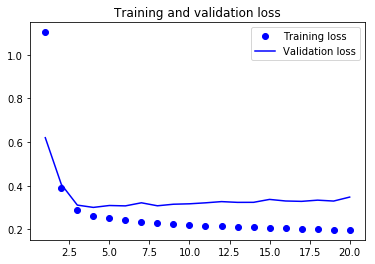

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

部分验证损失接近不包含学习的基准方法，但这个结果并不可靠。这也展示了首先建立这
个基准方法的优点，事实证明，超越这个基准并不容易。我们的常识中包含了大量有价值的信息，
而机器学习模型并不知道这些信息。

你可能会问，如果从数据到目标之间存在一个简单且表现良好的模型（即基于常识的基准
方法），那为什么我们训练的模型没有找到这个模型并进一步改进呢？原因在于，这个简单的解决方案并不是训练过程所要寻找的目标。我们在模型空间（即假设空间）中搜索解决方案，这
个模型空间是具有我们所定义的架构的所有两层网络组成的空间。这些网络已经相当复杂了。
如果你在一个复杂模型的空间中寻找解决方案，那么可能无法学到简单且性能良好的基准方法，
虽然技术上来说它属于假设空间的一部分。通常来说，这对机器学习是一个非常重要的限制：
如果学习算法没有被硬编码要求去寻找特定类型的简单模型，那么有时候参数学习是无法找到
简单问题的简单解决方案的。
### 6.3.5　第一个循环网络基准

In [21]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

W0807 09:38:10.221307 139809527601024 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
500/500 [==============================] - 172s 344ms/step - loss: 0.3037 - val_loss: 0.2717
Epoch 2/20
500/500 [==============================] - 172s 344ms/step - loss: 0.2844 - val_loss: 0.2674
Epoch 3/20
500/500 [==============================] - 172s 344ms/step - loss: 0.2762 - val_loss: 0.2754
Epoch 4/20
500/500 [==============================] - 171s 343ms/step - loss: 0.2735 - val_loss: 0.2655
Epoch 5/20
500/500 [==============================] - 172s 344ms/step - loss: 0.2678 - val_loss: 0.2641
Epoch 6/20
500/500 [==============================] - 171s 342ms/step - loss: 0.2661 - val_loss: 0.2714
Epoch 7/20
500/500 [==============================] - 171s 343ms/step - loss: 0.2595 - val_loss: 0.2662
Epoch 8/20
500/500 [==============================] - 171s 342ms/step - loss: 0.2557 - val_loss: 0.2653
Epoch 9/20
500/500 [==============================] - 172s 343ms/step - loss: 0.2523 - val_loss: 0.2679
Epoch 10/20
500/500 [==============================] - 171s 341m

In [0]:
def show_history(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

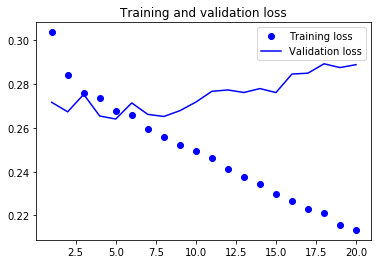

In [23]:
show_history(history)